In [1]:

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import nomic
#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")

import json
import os
import pickle


dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1')
bill_meta = pickle.load(open('bill_meta.p', 'rb'))

df = dataset.maps[0].data.df
df.head()

/cis/home/tchen94/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-11-22 14:17:42.797 | INFO     | nomic.dataset:__init__:768 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1`.
2024-11-22 14:17:43.416 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-11-22 14:17:43.426 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 129/129 [00:00<00:00, 593.69it/s]
2024-11-22 14:17:44.918 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 129/129 [00:03<00:00, 41.79it/s]


,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [2]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [2]:
#- Should be able to re-factor so that we are not keeping n_bills copies of embeddings / text
congress_name_list= list(df['name'].unique())   
n_congresspersons = len(congress_name_list)

name_to_standardized_name = {}

for name in congress_name_list:
    chunks = name.lower().split(' ')[:2]
    if ',' in chunks[0]:
        standardized_name = chunks[1] + '_' + chunks[0][:-1]
    else:
        standardized_name = chunks[0] + '_' + chunks[1]

    name_to_standardized_name[name] = unidecode(standardized_name)
standardized_name_list = list(name_to_standardized_name.values())
    
standardize_vote = {
    'Yea': 'yea', 
    'Aye': 'yea', 
    'Nay': 'nay', 
    'No': 'nay', 
    'Not Voting': 'not voting',
    'Present': 'not voting'
    }
    
cp_metadata_by_bill = {}
text_dict = {}
embd_dict = {}
for bill in tqdm(bill_meta):
    cp_metadata_by_bill[bill] = {}
    
    if bill_meta[bill]['house_vote_id'] == '':
        HOUSE = False
        congress_name_list_house = []
    else:
        HOUSE = True
        
    if bill_meta[bill]['senate_vote_id'] == '':
        SENATE = False
        congress_name_list_senate = []
        
    else:
        SENATE = True
    
    
    if HOUSE:
        year, month, day = bill_meta[bill]['house_vote_date'].split('-')
        house_t = pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        house_vote_id = bill_meta[bill]['house_vote_id']
        
        df_house = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{house_vote_id}.csv', header=0)
        congress_name_list_house = df_house['matched-name'].unique()
        congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]
        
        
    if SENATE:
        year, month, day = bill_meta[bill]['senate_vote_date'].split('-')
        senate_t =  pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        senate_vote_id = bill_meta[bill]['senate_vote_id']
    
        df_senate = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{senate_vote_id}.csv', header=0)
        congress_name_list_senate = df_senate['matched-name'].unique()
        congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]

    t_dict = {'house': house_t, 'senate': senate_t}
    
    #- Add all congress persons in Atlas dataframe to name_to_standardized_name
    for name in congress_name_list:
        party=df[df['name'] == name]['party'].values[0].lower()
        
        if name in congress_name_list_house:
            vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
            chamber='house'
        elif name in congress_name_list_senate:
            vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
            chamber='senate'
        else:
            vote='n/a'
            chamber=df[df['name'] == name]['chamber'].values[0].lower()
        
        standardized_name = name_to_standardized_name[name]
                    
        if standardized_name not in cp_metadata_by_bill[bill]:
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}
        elif cp_metadata_by_bill[bill][standardized_name]['vote'] == 'n/a':
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

100%|██████████| 13/13 [02:34<00:00, 11.90s/it]


In [3]:
with open('cmds_dict_inference_big.p', 'rb') as file:
    cmds_dict = pickle.load(file)

In [4]:
len(cmds_dict['117-HR-1319']['generated'].keys())

842

In [5]:
list(cmds_dict[bill]['retrieved'].keys())==list(cmds_dict[bill]['generated'].keys())

True

In [6]:
bi_cameral_bills = []

for bill in bill_meta:
    if bill_meta[bill]['senate_vote_id'] != '':
        bi_cameral_bills.append(bill)
        print(bill, bill_meta[bill]['senate_vote_id'])

117-HR-1319 117-2021_s110
117-HR-4346 117-2022_s271
118-HR-7888 118-2024_s150
118-HR-3746 118-2023_s146


In [7]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

score=accuracy_score

def get_indices_by_class(y):
    unique = np.unique(y)
            
    indices_by_class ={}
    for c in unique:
        indices_by_class[c] = np.where(y == c)[0]
        
    return indices_by_class

def get_stratified_folds(y, n_folds):
    indices_by_class = get_indices_by_class(y)
    folds = {i: {'train': [], 'test': []} for i in range(n_folds)}
        
    for c, indices in indices_by_class.items():
        test_per_fold = int(len(indices) *  (1 / n_folds))
        
        for i in range(n_folds):
            folds[i]['test']+= list(indices[i*test_per_fold: (i+1)*test_per_fold])
            
        
    for i in range(n_folds):
        folds[i]['train'] = np.array([j for j in range(len(y)) if j not in folds[i]['test']])
        folds[i]['test'] = np.array(folds[i]['test'])
        
    return folds

def get_stratified_sample(y, p):
    indices_by_class = get_indices_by_class(y)
    
    inds = []
    for c, indices in indices_by_class.items():
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict

In [8]:
from graspologic.plot import pairplot, heatmap

party_color_dict = {'d': 'tab:blue', 'r': 'tab:red', 'i': 'tab:green', 'n/a': 'k'}
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'k'}

party_by_bill = {}
vote_by_bill = {}
chamber_by_bill = {}
name_list_2 = {}

for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
    
    name_list = list(cmds_dict[bill]['retrieved'].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    party_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['party'] for name in name_list])
    vote_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['vote'] for name in name_list])
    name_list_2[bill] = np.array(name_list)
    chamber_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['chamber'] for name in name_list]) 
    
    party_list = party_by_bill[bill]

In [11]:
## tuning the knn k parameter:
n_folds= 10
n_neighbors_list = [1,5,10,20,50]

best_score_generated = {}
argbest_score_generated = {}
std_best_generated = {}

best_score_retrieved = {}
argbest_score_retrieved = {}
std_best_retrieved = {}

std_results_dict = {}
average_results_dict = {}

for bill in cp_metadata_by_bill:
    if bill_meta[bill]['house_vote_id'] == '' or bill_meta[bill]['senate_vote_id'] =='':
        continue

    average_results_dict[bill] = {}
    std_results_dict[bill] = {}
    
    best_score_generated[bill] = -1
    argbest_score_generated[bill] = -1
    std_best_generated[bill] = -1
    
    
    best_score_retrieved[bill] = -1
    argbest_score_retrieved[bill] = -1
    std_best_retrieved[bill] = -1
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    #voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])

    n_voters_house = len(voter_inds_house)
    #n_voters_senate = len(voter_inds_senate)
        
    folds = get_stratified_folds(vote_list[voter_inds_house], n_folds)
    
    results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}
    for k in n_neighbors_list:
        for mc in range(n_folds):
            train_inds = folds[mc]['train']
            test_inds = folds[mc]['test']
            
            for type_, cmds in cmds_dict[bill].items():
                model = KNeighborsClassifier(n_neighbors=k)
                
                cmds = np.array(list(cmds_dict[bill][type_].values()))
                model.fit(cmds[voter_inds_house][train_inds], vote_list[voter_inds_house][train_inds])

                y_pred = model.predict(cmds[voter_inds_house][test_inds])
                results_dict[k][type_].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            if k != n_neighbors_list[-1]:
                continue
                
            #- majority
            unique, return_counts = np.unique(vote_list[voter_inds_house][train_inds], return_counts=True)
            y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
            results_dict[k]['majority'].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            #- party line vote
            y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p] for p in party_list[voter_inds_house][test_inds]]
            results_dict[k]['party-line'].append(score(vote_list[voter_inds_house][test_inds], y_pred))


        if np.mean(results_dict[k]['generated']) > best_score_generated[bill]:
            best_score_generated[bill] = np.mean(results_dict[k]['generated'])
            argbest_score_generated[bill] = k
            std_best_generated[bill] = np.std(results_dict[k]['generated'])
            
        if np.mean(results_dict[k]['retrieved']) > best_score_retrieved[bill]:
            best_score_retrieved[bill] = np.mean(results_dict[k]['retrieved'])
            argbest_score_retrieved[bill] = k
            std_best_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            
    for type_, results in results_dict[k].items():
        average_results_dict[bill][type_] = np.mean(results)
        std_results_dict[bill][type_] = np.std(results)
        
    average_results_dict[bill]['retrieved'] = best_score_retrieved[bill]
    average_results_dict[bill]['generated'] = best_score_generated[bill]
    
    std_results_dict[bill]['retrieved'] = std_best_retrieved[bill]
    std_results_dict[bill]['generated'] = std_best_generated[bill]
    
    print(average_results_dict[bill])

print(argbest_score_generated)


{'retrieved': 0.6024390243902439, 'generated': 0.9560975609756097, 'majority': 0.5121951219512194, 'party-line': 0.9951219512195122}
{'retrieved': 0.61, 'generated': 0.9375, 'majority': 0.5, 'party-line': 0.9924999999999999}
{'retrieved': 0.65, 'generated': 0.785, 'majority': 0.6500000000000001, 'party-line': 0.6500000000000001}
{'retrieved': 0.7317073170731707, 'generated': 0.7390243902439024, 'majority': 0.7317073170731707, 'party-line': 0.7317073170731707}
{'117-HR-1319': 5, '117-HR-4346': 10, '118-HR-7888': 50, '118-HR-3746': 5}


117-HR-1319 0.9560975609756097
117-HR-4346 0.9375
118-HR-7888 0.785
118-HR-3746 0.7390243902439024


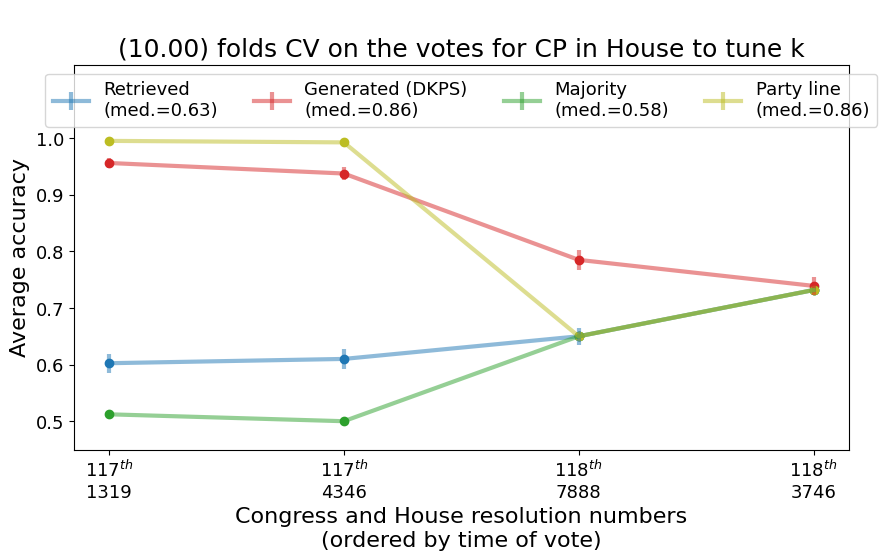

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bill_list = list(average_results_dict.keys())
# bill_list.remove('118-HR 1435')

method_list = list(average_results_dict[bill_list[0]].keys())

bill_labels= []
for bill in bill_list:
    if bill == '118-HR 1435':
        bill_labels.append(r'118$^{th}$'+'\n1435')
        continue
    split = bill.split('-')
    bill_labels.append(f'{split[0]}' + r'$^{th}$' + '\n' + split[2])

# markers=['*', '^', 'v']
# bill_to_marker = {bill: markers[i] for i, bill in enumerate(bill_list)}

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:olive']
method_to_color = {method: colors[i] for i, method in enumerate(method_list)}

legend_dict = {
    'retrieved': 'Retrieved', 
    'generated': 'Generated (DKPS)',
    'majority': 'Majority', 
    'party-line': 'Party line'
}

result_by_method = {method: [] for method in method_list}
std_by_method = {method: [] for method in method_list}
for i, bill in enumerate(bill_list):
    for j, (method, avg) in enumerate(average_results_dict[bill].items()):
        if method == 'generated':
            print(bill, avg)
        ax.scatter(i, avg, color=method_to_color[method])
        result_by_method[method].append(avg)
        std_by_method[method].append(std_results_dict[bill][method])
    
for method in result_by_method:
    median = np.median(result_by_method[method])
    ax.errorbar(range(len(bill_list)), result_by_method[method], yerr=std_by_method[method] / np.sqrt(10), color=method_to_color[method], alpha=0.5, lw=3, 
                label=legend_dict[method]+f'\n(med.={median:1.2f})')
    
ax.set_xticks(range(len(bill_list)), labels=bill_labels)
ax.set_xlabel('Congress and House resolution numbers\n(ordered by time of vote)', fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average accuracy', fontsize=16)
ax.set_title( f'\n({n_folds:1.2f}) folds CV on the votes for CP in House to tune k', fontsize=18)
# ax.set_xlim(-.05, 2.05)
ax.set_ylim(0.45, 1.13)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.legend(fontsize=13, loc='upper center', ncols=4)


In [13]:
argbest_score_generated

{'117-HR-1319': 5, '117-HR-4346': 10, '118-HR-7888': 50, '118-HR-3746': 5}

In [14]:
## predict on the senate vote

results_dict_senate = {}
senate_flip_score={}
house_flip_score={}

for bill in argbest_score_generated.keys():
    
    senate_flip_score[bill]={}
    results_dict_senate[bill] = {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []}
    
    ## train on all house votes
    
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    name_list=name_list_2[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    #- majority
    unique, return_counts = np.unique(vote_list[voter_inds_house], return_counts=True)
    y_pred = len(voter_inds_senate) * [unique[np.argmax(return_counts)]]
    results_dict_senate[bill]['majority'].append(score(vote_list[voter_inds_senate], y_pred))


    #- party line vote
    y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_senate]]
    results_dict_senate[bill]['party-line'].append(score(vote_list[voter_inds_senate], y_pred))
    cross_party_line = np.array([p != vote_list[voter_inds_senate][i] for i, p in enumerate(y_pred)])
    
    y_pred_h = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_house]]
    cross_party_line_h = np.array([p != vote_list[voter_inds_house][i] for i, p in enumerate(y_pred_h)])

    n_voters_house = len(voter_inds_house)
    
    #- generated 
    k = argbest_score_generated[bill]
    model = KNeighborsClassifier(n_neighbors=k)
                
    cmds = np.array(list(cmds_dict[bill]['generated'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])

    y_pred = model.predict(cmds[voter_inds_senate])
    y_pred_proba = model.predict_proba(cmds[voter_inds_senate])
    
    #print(name_list[voter_inds_senate],flip_score)
    
    senate_flip_score[bill] = {'cross_party_line': cross_party_line,
                               'name_list': name_list[voter_inds_senate],
                               'true_votes': vote_list[voter_inds_senate],
                               'party': party_list[voter_inds_senate]} 

    house_flip_score[bill] = { 'cross_party_line': cross_party_line_h,
                               'name_list': name_list[voter_inds_house],
                               'true_votes': vote_list[voter_inds_house],
                               'party': party_list[voter_inds_house]}

    
    results_dict_senate[bill]['generated'].append(score(vote_list[voter_inds_senate], y_pred))
    
    #-retrieved
    k = argbest_score_retrieved[bill]
    model = KNeighborsClassifier(n_neighbors=k)
    
    cmds = np.array(list(cmds_dict[bill]['retrieved'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])
    
    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate[bill]['retrieved'].append(score(vote_list[voter_inds_senate], y_pred))
    print(bill, results_dict_senate[bill])
    
        

117-HR-1319 {'retrieved': [0.5212765957446809], 'generated': [0.9361702127659575], 'majority': [0.5212765957446809], 'party-line': [1.0]}
117-HR-4346 {'retrieved': [0.5108695652173914], 'generated': [0.7282608695652174], 'majority': [0.6739130434782609], 'party-line': [0.8152173913043478]}
118-HR-7888 {'retrieved': [0.686046511627907], 'generated': [0.7441860465116279], 'majority': [0.686046511627907], 'party-line': [0.686046511627907]}
118-HR-3746 {'retrieved': [0.6483516483516484], 'generated': [0.7032967032967034], 'majority': [0.6483516483516484], 'party-line': [0.6483516483516484]}


In [15]:
bill_key=bi_cameral_bills[3]

n_neighbors_list= [2,3,4,5,10,20,30,50]
for k in n_neighbors_list:
    model = KNeighborsClassifier(n_neighbors=k)            
    cmds = np.array(list(cmds_dict[bill_key]['generated'].values()))
    
    vote_list = vote_by_bill[bill_key]
    party_list = party_by_bill[bill_key]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    y_pred_h = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_house]]
    cross_party_line_h = np.array([p != vote_list[voter_inds_house][i] for i, p in enumerate(y_pred_h)])
    
    y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_senate]]
    cross_party_line = np.array([p != vote_list[voter_inds_senate][i] for i, p in enumerate(y_pred)])
    
    model.fit(cmds[voter_inds_house], cross_party_line_h)  

    #y_pred = model.predict(cmds[voter_inds_house][test_inds])
    #results_dict[k][type_].append(score(vote_list[voter_inds_house][test_inds], y_pred))
    
    y_pred = model.predict(cmds[voter_inds_house])
    print('House_train',score(cross_party_line_h, y_pred))
    
    y_pred = model.predict(cmds[voter_inds_senate])
    
    
    print('Senate_test',score(cross_party_line, y_pred))

House_train 0.8459715639810427
Senate_test 0.7032967032967034
House_train 0.8412322274881516
Senate_test 0.7032967032967034
House_train 0.8151658767772512
Senate_test 0.7252747252747253
House_train 0.8127962085308057
Senate_test 0.7032967032967034
House_train 0.7890995260663507
Senate_test 0.7362637362637363
House_train 0.7582938388625592
Senate_test 0.7252747252747253
House_train 0.7511848341232228
Senate_test 0.7142857142857143
House_train 0.7274881516587678
Senate_test 0.6483516483516484


In [16]:
model.predict_proba(cmds[voter_inds_senate])

array([[0.82, 0.18],
       [0.56, 0.44],
       [0.62, 0.38],
       [0.58, 0.42],
       [0.62, 0.38],
       [0.94, 0.06],
       [0.94, 0.06],
       [0.94, 0.06],
       [0.74, 0.26],
       [0.8 , 0.2 ],
       [0.66, 0.34],
       [0.92, 0.08],
       [0.78, 0.22],
       [0.9 , 0.1 ],
       [0.66, 0.34],
       [0.9 , 0.1 ],
       [0.94, 0.06],
       [0.6 , 0.4 ],
       [0.6 , 0.4 ],
       [0.7 , 0.3 ],
       [0.76, 0.24],
       [0.56, 0.44],
       [0.86, 0.14],
       [0.72, 0.28],
       [0.84, 0.16],
       [0.58, 0.42],
       [0.8 , 0.2 ],
       [0.9 , 0.1 ],
       [0.72, 0.28],
       [0.86, 0.14],
       [0.54, 0.46],
       [0.94, 0.06],
       [0.58, 0.42],
       [0.64, 0.36],
       [0.56, 0.44],
       [0.9 , 0.1 ],
       [0.76, 0.24],
       [0.8 , 0.2 ],
       [0.76, 0.24],
       [0.66, 0.34],
       [0.58, 0.42],
       [0.76, 0.24],
       [0.84, 0.16],
       [0.8 , 0.2 ],
       [0.58, 0.42],
       [0.64, 0.36],
       [0.68, 0.32],
       [0.66,

In [17]:
bill_meta['117-HR-1319']['house_vote_id']

'117-2021_h49'

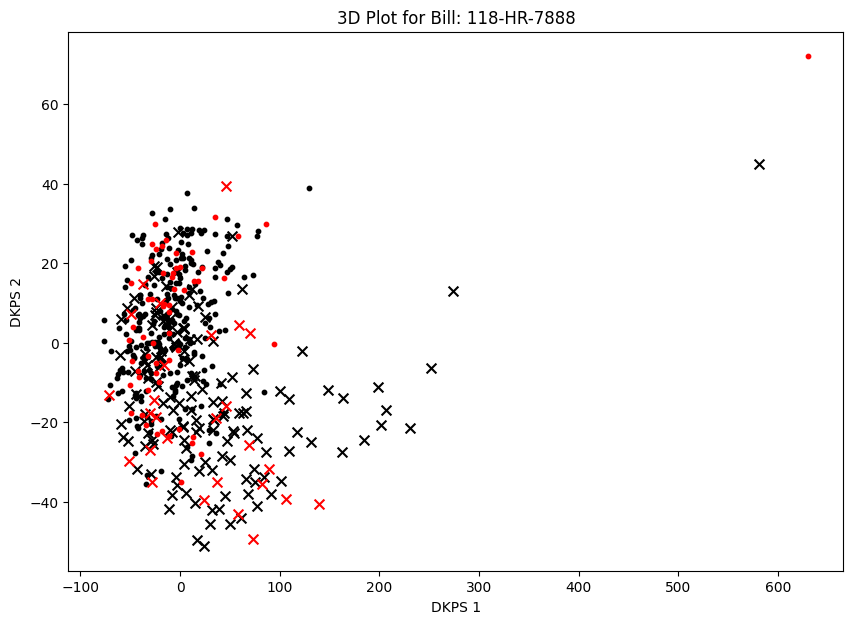

In [ ]:
bill_key=bi_cameral_bills[2]
house_name=house_flip_score[bill_key]['name_list']
senate_name=senate_flip_score[bill_key]['name_list']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

for i, name in enumerate(house_name):
    ax.scatter(
            cmds_dict[bill_key]['generated'][name][0], 
            cmds_dict[bill_key]['generated'][name][1], 
            color='black', 
            marker='x' if house_flip_score[bill_key]['cross_party_line'][i] else 'o', 
            s=50 if house_flip_score[bill_key]['cross_party_line'][i] else 10
        )

for i,name in enumerate(senate_name):
    ax.scatter(
            cmds_dict[bill_key]['generated'][name][0], 
            cmds_dict[bill_key]['generated'][name][1], 
            color='red', 
            marker='x' if senate_flip_score[bill_key]['cross_party_line'][i] else 'o', 
            s=50 if senate_flip_score[bill_key]['cross_party_line'][i] else 10
        )

ax.set_xlabel('DKPS 1')
ax.set_ylabel('DKPS 2')
ax.set_title(f'3D Plot for Bill: {bill_key}')
plt.show()

In [ ]:
from collections import defaultdict

def calculate_proportion_per_flip_score(senate_flip_score, bill_key):
    if bill_key not in senate_flip_score:
        raise KeyError(f"Bill key '{bill_key}' not found in the data.")
    
    bill_data = senate_flip_score[bill_key]
    if 'cross_party_line' not in bill_data or 'flip_score_2' not in bill_data:
        raise ValueError(f"Required fields missing in bill data: {bill_key}")
    
    flip_scores = bill_data['flip_score_2']
    cross_party_line = bill_data['cross_party_line']
    
    if len(flip_scores) != len(cross_party_line):
        raise ValueError("The lengths of 'flip_score_2' and 'cross_party_line' must match.")
    
    flip_score_groups = defaultdict(list)
    for flip_score, crossed in zip(flip_scores, cross_party_line):
        flip_score_groups[flip_score].append(crossed)
    
    flip_proportions = {}
    for score, flips in flip_score_groups.items():
        flip_proportions[score] = sum(flips) / len(flips) if flips else 0.0
    
    return flip_proportions

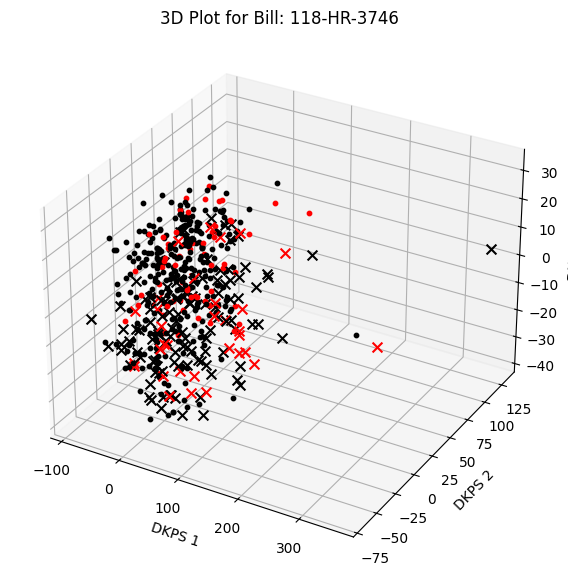

In [34]:
bill_key=bi_cameral_bills[3]
house_name=house_flip_score[bill_key]['name_list']
senate_name=senate_flip_score[bill_key]['name_list']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, name in enumerate(house_name):
    ax.scatter(
            cmds_dict[bill_key]['generated'][name][0], 
            cmds_dict[bill_key]['generated'][name][1], 
            cmds_dict[bill_key]['generated'][name][2],
            color='black', 
            marker='x' if house_flip_score[bill_key]['cross_party_line'][i] else 'o', 
            s=50 if house_flip_score[bill_key]['cross_party_line'][i] else 10
        )

for i,name in enumerate(senate_name):
    ax.scatter(
            cmds_dict[bill_key]['generated'][name][0], 
            cmds_dict[bill_key]['generated'][name][1], 
            cmds_dict[bill_key]['generated'][name][2],
            color='red', 
            marker='x' if senate_flip_score[bill_key]['cross_party_line'][i] else 'o', 
            s=50 if senate_flip_score[bill_key]['cross_party_line'][i] else 10
        )

ax.set_xlabel('DKPS 1')
ax.set_ylabel('DKPS 2')
ax.set_zlabel('DKPS 3')
ax.set_title(f'3D Plot for Bill: {bill_key}')
plt.show()

In [174]:
from scipy.spatial.distance import euclidean
for bill_key, senate_data in senate_flip_score.items():
        # Retrieve the list of senator names for the current bill
    senate_names = senate_data['name_list']
    senate_flip_score[bill_key]['flip_score_3']=[]

    for senator_name in senate_names:
            # Find the senator's party
        senator_party = senate_data['party'][senate_data['name_list'] == senator_name][0]
            # Find house reps from the same party who crossed party lines
        house_data = house_flip_score[bill_key]
        cross_party_reps = house_data['name_list'][(house_data['party'] == senator_party) & (house_data['cross_party_line'] == True)]
        #cross_party_reps = house_data['name_list'][(house_data['cross_party_line'] == True)]

        
        if len(cross_party_reps)==0:
            flip_score = 0 
        else:
            senator_embedding = cmds_dict[bill_key]['generated'][senator_name]
            distances = [
                euclidean(senator_embedding, cmds_dict[bill_key]['generated'][rep])
                for rep in cross_party_reps
            ]
            distance = np.min(distances)
            flip_score = 1/distance
            
        senate_flip_score[bill_key]['flip_score_3'].append(flip_score)
    
        # Assuming senate_flip_score and bill_key are defined
    flip_score_3 = np.array(senate_flip_score[bill_key]['flip_score_3'])
    # Create custom bins with finer levels close to 0
    min_val = np.min(flip_score_3)
    max_val = np.max(flip_score_3)
    bins = np.concatenate([
        np.linspace(min_val, 0.2 * max_val, 6),  # Finer bins close to 0
        np.linspace(0.2 * max_val, max_val, 4)  # Coarser bins for the rest
    ])

    # Discretize the flip_score_3 values using the custom bins
    senate_flip_score[bill_key]['flip_score_4'] = np.digitize(flip_score_3, bins)
    

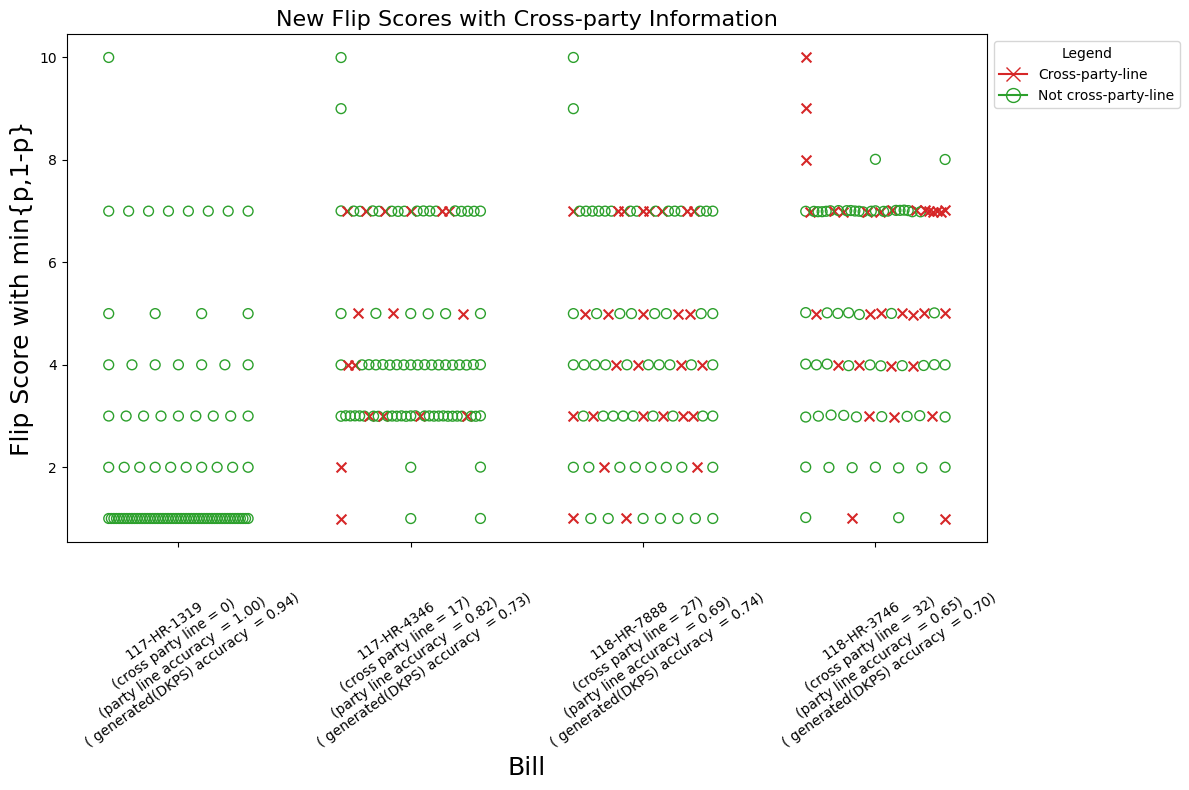

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Flatten the data into a DataFrame
data = []
for bill in senate_flip_score:
    flip_scores_2 = senate_flip_score[bill]['flip_score_4']
    names = senate_flip_score[bill]['name_list']
    parties = senate_flip_score[bill]['party']
    cross_party_line = senate_flip_score[bill]['cross_party_line']
    
    for i, s in enumerate(flip_scores_2):
        data.append({
            'Bill': bill,
            'Flip Score': s,
            'Name': names[i],
            'Party': parties[i],
            'Cross-party-line': cross_party_line[i],
        })

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Unique bills for positioning on x-axis and calculate cross-party-line totals
bills = df['Bill'].unique()
bill_labels = [f"{bill}\n(cross party line = {df[df['Bill'] == bill]['Cross-party-line'].sum()})\n(party line accuracy  = {results_dict_senate[bill]['party-line'][0]:1.2f})\n( generated(DKPS) accuracy  = {results_dict_senate[bill]['generated'][0]:1.2f})" for bill in bills]
# Define color and marker based on cross-party line status
cross_party_line_colors = {True: 'tab:red', False: 'tab:green'}

# Set the amount of horizontal jitter
horizontal_jitter_strength = 0.3

# Define vertical jitter strength as a list with a specific value for each bill
# Ensure the length of this list matches the number of unique bills
vertical_jitter_strengths = [0.0, 0.005, 0.0, 0.02]  # Example values for 4 bills

# Create the plot
plt.figure(figsize=(12, 8))

# Iterate over each unique combination of Bill and Flip Score to avoid overlap
for (bill, s), group in df.groupby(['Bill', 'Flip Score']):
    # Determine the vertical jitter strength for this bill
    bill_index = np.where(bills == bill)[0][0]
    vertical_jitter = vertical_jitter_strengths[bill_index]
    
    # Add horizontal jitter for each point in the group
    x_positions = np.linspace(-horizontal_jitter_strength, horizontal_jitter_strength, len(group)) + bill_index

    for i, (_, row) in enumerate(group.iterrows()):
        # Set color and marker based on cross-party line vote status
        color = cross_party_line_colors[row['Cross-party-line']]
        marker = 'x' if row['Cross-party-line'] else 'o'
        
        # Add vertical jitter to the score based on the specific bill's jitter strength
        y_position = s + np.random.uniform(-vertical_jitter, vertical_jitter)
        
        # Scatter plot each point with adjusted x and y position
        if row['Cross-party-line']:
            plt.scatter(x_positions[i], y_position, color=color, marker=marker, s=50)  # Filled "x" marker for cross-party
        else:
            plt.scatter(x_positions[i], y_position, edgecolor=color, facecolors='none', marker=marker, s=50)  # Hollow "o" marker for non-cross-party

# Add custom legend for cross-party status
legend_elements = [
    plt.Line2D([0], [0], marker='x', color='tab:red', markersize=10, label='Cross-party-line'),
    plt.Line2D([0], [0], marker='o', color='tab:green', markerfacecolor='none', markersize=10, label='Not cross-party-line')
]
plt.legend(handles=legend_elements, title="Legend", loc="upper left", bbox_to_anchor=(1, 1))

# Customize plot appearance with updated x-axis labels
plt.xticks(ticks=range(len(bills)), labels=bill_labels, rotation=35, fontsize=10)
plt.xlabel('Bill', fontsize=18)
plt.ylabel('Flip Score with min{p,1-p}', fontsize=18)
plt.title('New Flip Scores with Cross-party Information', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()

117-HR-1319
117-HR-4346
118-HR-7888
118-HR-3746


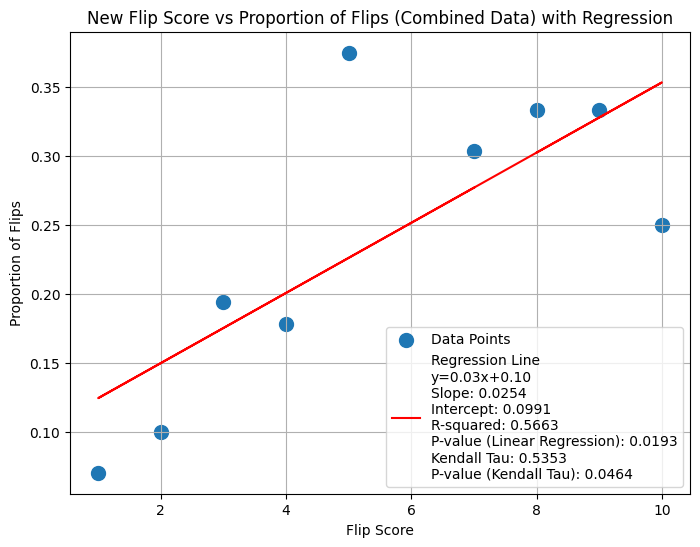

In [176]:
# Combine the data for all four bills
from scipy.stats import linregress

combined_flip_scores = []
combined_cross_party_line = []

#selected_bills = [bi_cameral_bills[1], bi_cameral_bills[2] ,bi_cameral_bills[3]] 
#selected_bills = [bi_cameral_bills[1], bi_cameral_bills[3]] 
selected_bills = bi_cameral_bills

for bill_key in selected_bills:
    print(bill_key)
    bill_data = senate_flip_score[bill_key]
    combined_flip_scores.extend(bill_data['flip_score_4'])
    combined_cross_party_line.extend(bill_data['cross_party_line'])

# Calculate proportions for combined data
flip_score_groups = defaultdict(list)
for flip_score, crossed in zip(combined_flip_scores, combined_cross_party_line):
    flip_score_groups[flip_score].append(crossed)

proportions_combined = {score: sum(flips) / len(flips) for score, flips in flip_score_groups.items()}
flip_scores_combined = list(proportions_combined.keys())
proportions_of_flips_combined = list(proportions_combined.values())

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(flip_scores_combined, proportions_of_flips_combined)

# Generate regression line values
regression_line = [slope * x + intercept for x in flip_scores_combined]


from scipy.stats import kendalltau

# Calculate Kendall Tau and p-value
kendall_tau, kendall_p_value = kendalltau(flip_scores_combined, proportions_of_flips_combined)

# Generate regression line values
regression_line = [slope * x + intercept for x in flip_scores_combined]

# Plot scatter and regression line
plt.figure(figsize=(8, 6))
plt.scatter(flip_scores_combined, proportions_of_flips_combined, s=100, label='Data Points')
plt.plot(flip_scores_combined, regression_line, color='red', 
         label=(f'Regression Line\ny={slope:.2f}x+{intercept:.2f}\n'
                f'Slope: {slope:.4f}\n'
                f'Intercept: {intercept:.4f}\n'
                f'R-squared: {r_value**2:.4f}\n'
                f'P-value (Linear Regression): {p_value:.4f}\n'
                f'Kendall Tau: {kendall_tau:.4f}\n'
                f'P-value (Kendall Tau): {kendall_p_value:.4f}'))
plt.title('New Flip Score vs Proportion of Flips (Combined Data) with Regression')
plt.xlabel('Flip Score')
plt.ylabel('Proportion of Flips')
plt.legend(loc='best')
plt.grid(True)
plt.show()

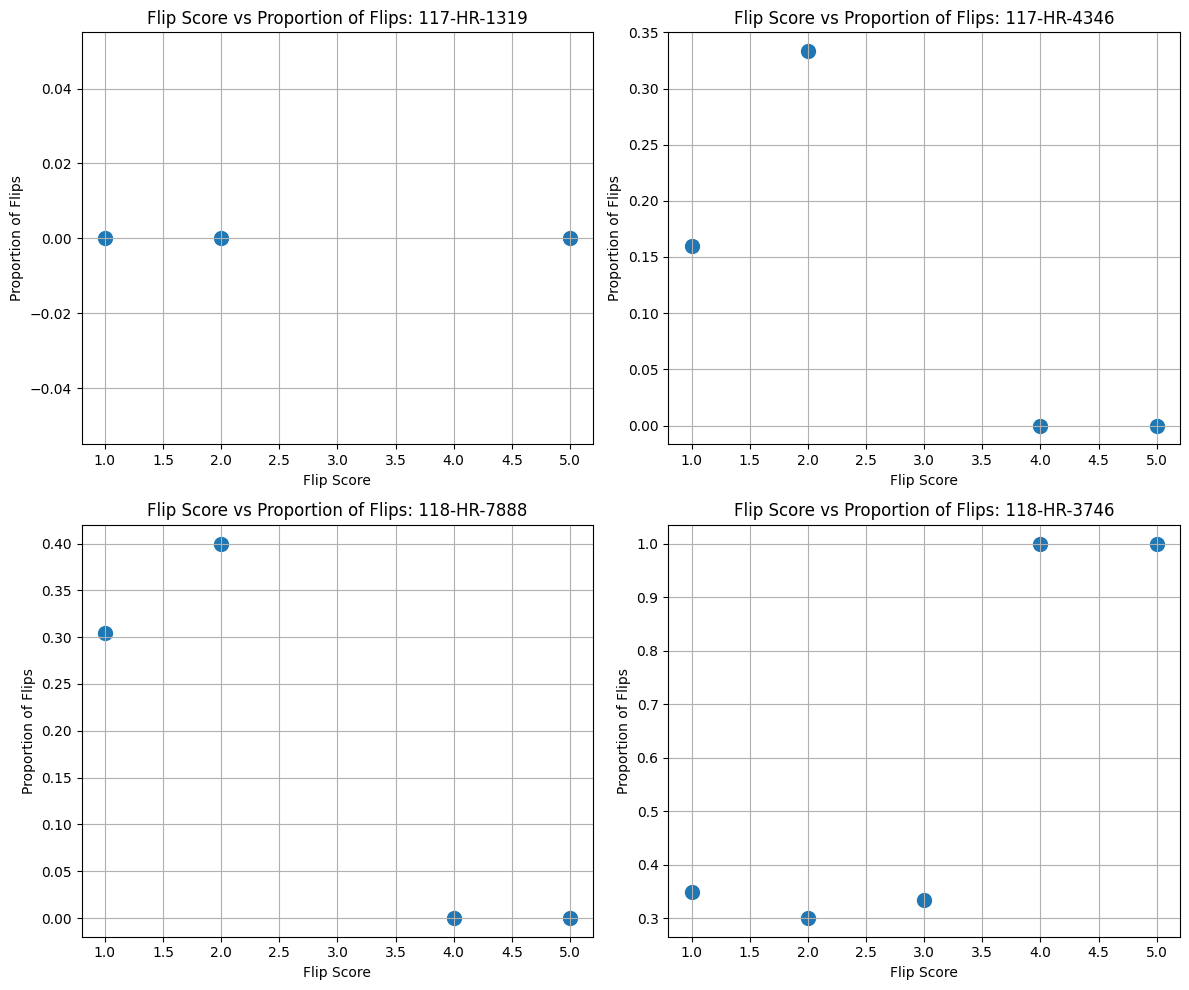

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, bill_key in enumerate(bi_cameral_bills):
    bill_data = senate_flip_score[bill_key]
    flip_scores = bill_data['flip_score_4']
    cross_party_line = bill_data['cross_party_line']

    flip_score_groups = defaultdict(list)
    for flip_score, crossed in zip(flip_scores, cross_party_line):
        flip_score_groups[flip_score].append(crossed)

    proportions = {score: sum(flips) / len(flips) for score, flips in flip_score_groups.items()}
    flip_scores_unique = list(proportions.keys())
    proportions_of_flips = list(proportions.values())
    
    axes[i].scatter(flip_scores_unique, proportions_of_flips, s=100)
    axes[i].set_title(f'Flip Score vs Proportion of Flips: {bill_key}')
    axes[i].set_xlabel('Flip Score')
    axes[i].set_ylabel('Proportion of Flips')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

117-HR-4346
118-HR-7888
118-HR-3746


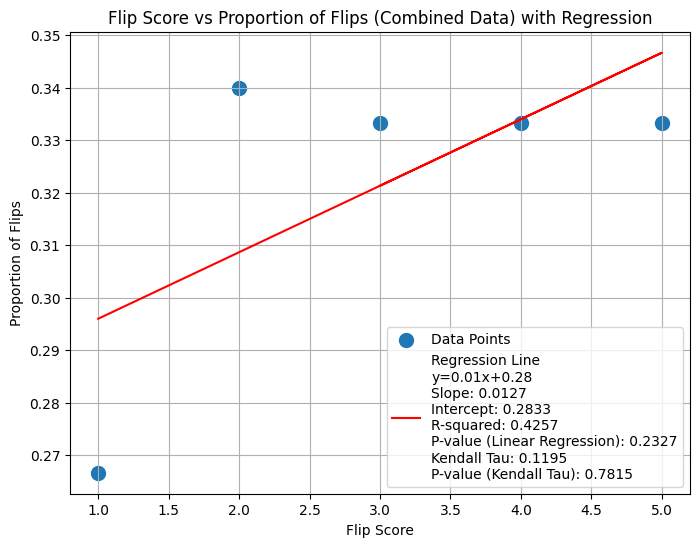

In [110]:
# Combine the data for all four bills
combined_flip_scores = []
combined_cross_party_line = []

selected_bills = [bi_cameral_bills[1], bi_cameral_bills[2] ,bi_cameral_bills[3]] 

for bill_key in selected_bills:
    print(bill_key)
    bill_data = senate_flip_score[bill_key]
    combined_flip_scores.extend(bill_data['flip_score_4'])
    combined_cross_party_line.extend(bill_data['cross_party_line'])

# Calculate proportions for combined data
flip_score_groups = defaultdict(list)
for flip_score, crossed in zip(combined_flip_scores, combined_cross_party_line):
    flip_score_groups[flip_score].append(crossed)

proportions_combined = {score: sum(flips) / len(flips) for score, flips in flip_score_groups.items()}
flip_scores_combined = list(proportions_combined.keys())
proportions_of_flips_combined = list(proportions_combined.values())

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(flip_scores_combined, proportions_of_flips_combined)

# Generate regression line values
regression_line = [slope * x + intercept for x in flip_scores_combined]


from scipy.stats import kendalltau

# Calculate Kendall Tau and p-value
kendall_tau, kendall_p_value = kendalltau(flip_scores_combined, proportions_of_flips_combined)

# Generate regression line values
regression_line = [slope * x + intercept for x in flip_scores_combined]

# Plot scatter and regression line
plt.figure(figsize=(8, 6))
plt.scatter(flip_scores_combined, proportions_of_flips_combined, s=100, label='Data Points')
plt.plot(flip_scores_combined, regression_line, color='red', 
         label=(f'Regression Line\ny={slope:.2f}x+{intercept:.2f}\n'
                f'Slope: {slope:.4f}\n'
                f'Intercept: {intercept:.4f}\n'
                f'R-squared: {r_value**2:.4f}\n'
                f'P-value (Linear Regression): {p_value:.4f}\n'
                f'Kendall Tau: {kendall_tau:.4f}\n'
                f'P-value (Kendall Tau): {kendall_p_value:.4f}'))
plt.title('Flip Score vs Proportion of Flips (Combined Data) with Regression')
plt.xlabel('Flip Score')
plt.ylabel('Proportion of Flips')
plt.legend(loc='best')
plt.grid(True)
plt.show()

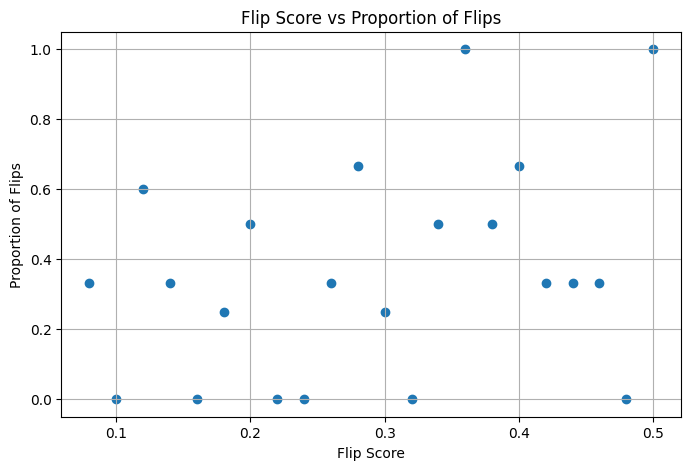

In [48]:
import matplotlib.pyplot as plt

bill_key = bi_cameral_bills[2]  # Referring to the first bill in bi_cameral_bills
proportions = calculate_proportion_per_flip_score(senate_flip_score, bill_key)

# Plotting Flip Score vs Proportion of Flips
flip_scores = list(proportions.keys())
proportions_of_flips = list(proportions.values())

plt.figure(figsize=(8, 5))
plt.scatter(flip_scores, proportions_of_flips, marker='o')
plt.title('Flip Score vs Proportion of Flips')
plt.xlabel('Flip Score')
plt.ylabel('Proportion of Flips')
plt.grid(True)
plt.show()

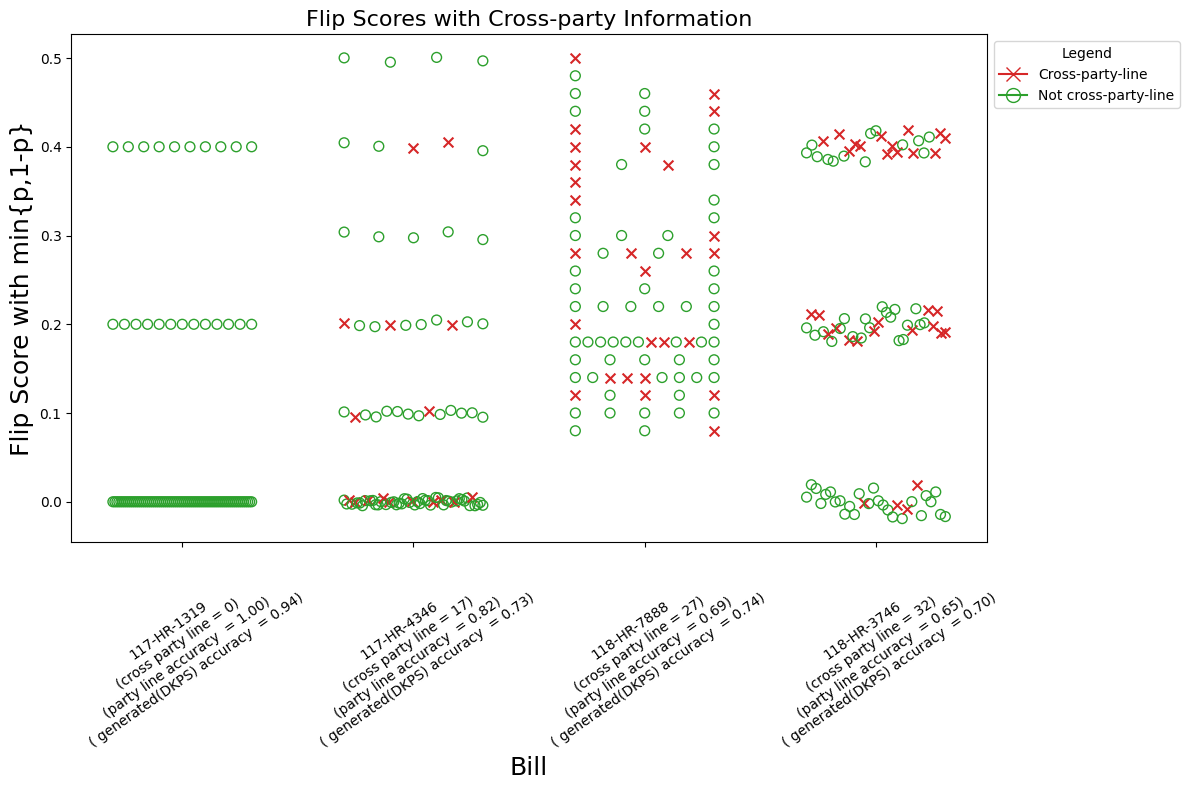

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Flatten the data into a DataFrame
data = []
for bill in senate_flip_score:
    flip_scores_2 = senate_flip_score[bill]['flip_score_2']
    names = senate_flip_score[bill]['name_list']
    parties = senate_flip_score[bill]['party']
    cross_party_line = senate_flip_score[bill]['cross_party_line']
    
    for i, s in enumerate(flip_scores_2):
        data.append({
            'Bill': bill,
            'Flip Score': s,
            'Name': names[i],
            'Party': parties[i],
            'Cross-party-line': cross_party_line[i],
        })

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Unique bills for positioning on x-axis and calculate cross-party-line totals
bills = df['Bill'].unique()
bill_labels = [f"{bill}\n(cross party line = {df[df['Bill'] == bill]['Cross-party-line'].sum()})\n(party line accuracy  = {results_dict_senate[bill]['party-line'][0]:1.2f})\n( generated(DKPS) accuracy  = {results_dict_senate[bill]['generated'][0]:1.2f})" for bill in bills]
# Define color and marker based on cross-party line status
cross_party_line_colors = {True: 'tab:red', False: 'tab:green'}

# Set the amount of horizontal jitter
horizontal_jitter_strength = 0.3

# Define vertical jitter strength as a list with a specific value for each bill
# Ensure the length of this list matches the number of unique bills
vertical_jitter_strengths = [0.0, 0.005, 0.0, 0.02]  # Example values for 4 bills

# Create the plot
plt.figure(figsize=(12, 8))

# Iterate over each unique combination of Bill and Flip Score to avoid overlap
for (bill, s), group in df.groupby(['Bill', 'Flip Score']):
    # Determine the vertical jitter strength for this bill
    bill_index = np.where(bills == bill)[0][0]
    vertical_jitter = vertical_jitter_strengths[bill_index]
    
    # Add horizontal jitter for each point in the group
    x_positions = np.linspace(-horizontal_jitter_strength, horizontal_jitter_strength, len(group)) + bill_index

    for i, (_, row) in enumerate(group.iterrows()):
        # Set color and marker based on cross-party line vote status
        color = cross_party_line_colors[row['Cross-party-line']]
        marker = 'x' if row['Cross-party-line'] else 'o'
        
        # Add vertical jitter to the score based on the specific bill's jitter strength
        y_position = s + np.random.uniform(-vertical_jitter, vertical_jitter)
        
        # Scatter plot each point with adjusted x and y position
        if row['Cross-party-line']:
            plt.scatter(x_positions[i], y_position, color=color, marker=marker, s=50)  # Filled "x" marker for cross-party
        else:
            plt.scatter(x_positions[i], y_position, edgecolor=color, facecolors='none', marker=marker, s=50)  # Hollow "o" marker for non-cross-party

# Add custom legend for cross-party status
legend_elements = [
    plt.Line2D([0], [0], marker='x', color='tab:red', markersize=10, label='Cross-party-line'),
    plt.Line2D([0], [0], marker='o', color='tab:green', markerfacecolor='none', markersize=10, label='Not cross-party-line')
]
plt.legend(handles=legend_elements, title="Legend", loc="upper left", bbox_to_anchor=(1, 1))

# Customize plot appearance with updated x-axis labels
plt.xticks(ticks=range(len(bills)), labels=bill_labels, rotation=35, fontsize=10)
plt.xlabel('Bill', fontsize=18)
plt.ylabel('Flip Score with min{p,1-p}', fontsize=18)
plt.title('Flip Scores with Cross-party Information', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

bill_key=bi_cameral_bills[3]

# Extract the features and target variable
X = np.array(senate_flip_score[bill_key]['flip_score_3']).reshape(-1, 1)
y = np.array(senate_flip_score[bill_key]['cross_party_line'])

# Initialize and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict the probabilities
y_pred_proba = log_reg.predict_proba(X)[:, 1]

# Predict the classes
y_pred = log_reg.predict(X)

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, y_pred_proba, color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Flip Score 3')
plt.ylabel('Probability of Cross Party Line')
plt.title(f'Logistic Regression: Flip Score 3 vs Cross Party Line for Bill: {bill_key}')
plt.legend()
plt.grid(True)
plt.show()

'117-2021_h49'

In [71]:
for ii in range(4):
    print(np.array(list(cmds_dict[bi_cameral_bills[ii]]['generated'].values())).shape)

(842, 2)
(842, 3)
(842, 2)
(842, 3)


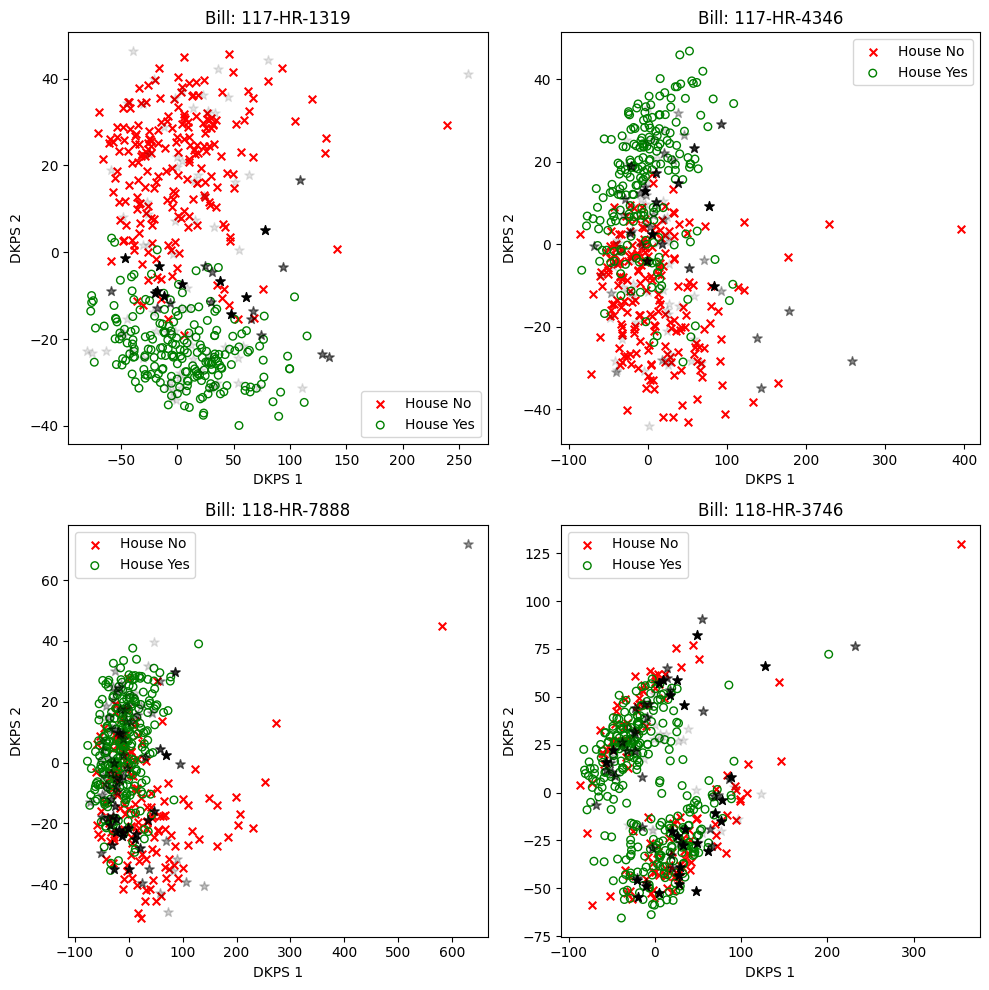

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Color dictionary for each vote type (no longer necessary for House 'yea' and 'nay', but retained if needed elsewhere)
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'tab:blue'}

# Select four bills to display in a 2x2 grid
selected_bills = bi_cameral_bills[:4]

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Loop over the selected bills and respective subplot locations
for idx, bill in enumerate(selected_bills):
    
    # Determine the position in the 2x2 grid
    row, col = divmod(idx, 2)
    ax = axs[row, col]
    
    # Retrieve vote list and indices for house and senate voters
    vote_list = vote_by_bill[bill]
    voter_inds_house_no = np.array([i for i, v in enumerate(vote_list) if v == 'nay' and chamber_by_bill[bill][i] == 'house'])
    voter_inds_house_yes = np.array([i for i, v in enumerate(vote_list) if v == 'yea' and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    # Retrieve 2D coordinates (first two dimensions)
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))
    
    # Scatter plot for House "No" votes as red 'x'
    ax.scatter(
        cmds_generated[voter_inds_house_no, 0], 
        cmds_generated[voter_inds_house_no, 1], 
        color='red', 
        marker='x', 
        s=30, 
        label='House No'
    )
    
    # Scatter plot for House "Yes" votes as hollow green circles
    ax.scatter(
        cmds_generated[voter_inds_house_yes, 0], 
        cmds_generated[voter_inds_house_yes, 1], 
        edgecolor='green', 
        facecolor='none', 
        marker='o', 
        s=30, 
        label='House Yes'
    )
    
    # Scatter plot for Senators with black stars and color density based on rescaled flip score
    all_names = [senate_flip_score[bill]['name_list'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]]
    flip_scores = np.array([senate_flip_score[bill]['flip_score_2'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]])
    
    # Rescale flip scores to range 0 to 1
    flip_score_min = flip_scores.min()
    flip_score_max = flip_scores.max()
    color_density = (flip_scores - flip_score_min) / (flip_score_max - flip_score_min)*0.9+0.1


    # Plot each senator with a black star and varying color density based on flip score
    # Plot each senator with alpha based on rescaled flip score
    for i, name in enumerate(all_names):
        ax.scatter(
            cmds_dict[bill]['generated'][name][0], 
            cmds_dict[bill]['generated'][name][1], 
            color='black', 
            marker='*', 
            s=50, 
            alpha=color_density[i]  # Set transparency based on normalized flip score
        )
    
    
    # Set axis labels and plot title for each subplot
    ax.set_xlabel('DKPS 1', fontsize=10)
    ax.set_ylabel('DKPS 2', fontsize=10)
    ax.set_title(f'Bill: {bill}', fontsize=12)
    ax.legend()

# Adjust layout for a cleaner appearance
plt.tight_layout()
plt.show()

In [44]:
vote_by_bill[bill]
bi_cameral_bills[1]

'117-HR-4346'

In [111]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.lines as mlines


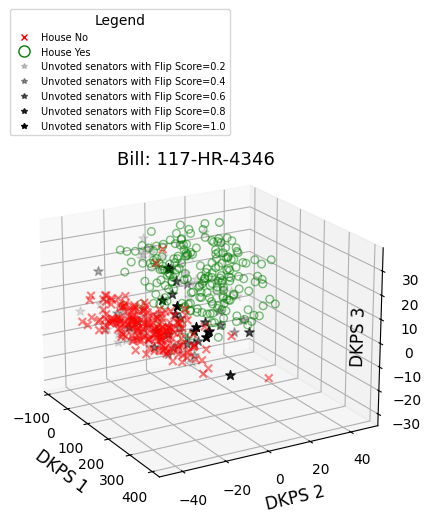

In [128]:
# Color dictionary for each vote type
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'tab:blue'}

bill=bi_cameral_bills[1]
    
    # Set up figure and 3D axes
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
    
    # Retrieve vote list and indices for house and senate voters
vote_list = vote_by_bill[bill]
voter_inds_house_no = np.array([i for i, v in enumerate(vote_list) if v == 'nay' and chamber_by_bill[bill][i] == 'house'])
voter_inds_house_yes = np.array([i for i, v in enumerate(vote_list) if v == 'yea' and chamber_by_bill[bill][i] == 'house'])
voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    
    # Retrieve 3D coordinates
cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))
    # Scatter plot for House "No" votes as red 'x'
ax.scatter(
        cmds_generated[voter_inds_house_no, 0], 
        cmds_generated[voter_inds_house_no, 1], 
        cmds_generated[voter_inds_house_no, 2], 
        color='red', 
        marker='x', 
        s=30, 
        label='House No',
        alpha=0.5
    )
    
    # Scatter plot for House "Yes" votes as hollow green circles
ax.scatter(
        cmds_generated[voter_inds_house_yes, 0], 
        cmds_generated[voter_inds_house_yes, 1], 
        cmds_generated[voter_inds_house_yes, 2], 
        edgecolor='green', 
        facecolor='none', 
        marker='o', 
        s=30, 
        label='House Yes',
        alpha=0.5
    )

    # Scatter plot for Senators with black stars and color density based on rescaled flip score
all_names = [senate_flip_score[bill]['name_list'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]]
flip_scores = np.array([senate_flip_score[bill]['flip_score_2'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]])
    
    # Rescale flip scores to range 0 to 1
flip_score_min = flip_scores.min()
flip_score_max = flip_scores.max()
color_density = (flip_scores - flip_score_min) / (flip_score_max - flip_score_min)*0.9+0.1
    
for i, name in enumerate(all_names):
    ax.scatter(
            cmds_dict[bill]['generated'][name][0], 
            cmds_dict[bill]['generated'][name][1],
            cmds_dict[bill]['generated'][name][2],
            color='black', 
            marker='*', 
            s=50, 
            alpha=color_density[i]  # Set transparency based on normalized flip score
        )
    # Set axis labels and plot title
ax.set_xlabel('DKPS 1', fontsize=12)
ax.set_ylabel('DKPS 2', fontsize=12)
ax.set_zlabel('DKPS 3', fontsize=12, labelpad=-30)

# Create custom handles for the legend
house_no_handle = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=4, label='House No')
house_yes_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor='none', markersize=8, label='House Yes')

# Handles for flip score with varying transparency
flip_score_handles = [
    mlines.Line2D([], [], color='black', alpha=alpha, marker='*', linestyle='None', markersize=4, 
                  label=f'Unvoted senators with Flip Score={alpha:.1f}') for alpha in [0.2, 0.4, 0.6, 0.8, 1.0]
]

# Flatten the list of handles
all_handles = [house_no_handle, house_yes_handle] + flip_score_handles

# Add legend to the plot
ax.legend(handles=all_handles, loc=[0,1], fontsize=7, title='Legend')


fig.suptitle(f'Bill: {bill}', fontsize=13, x=0.5, y=0.85)

angle=330
ax.view_init(elev=20, azim=angle)


plt.show()

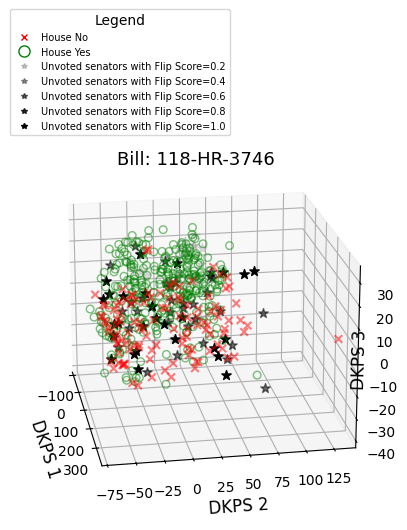

In [129]:
# Color dictionary for each vote type
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'tab:blue'}

bill=bi_cameral_bills[3]
    
    # Set up figure and 3D axes
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
    
    # Retrieve vote list and indices for house and senate voters
vote_list = vote_by_bill[bill]
voter_inds_house_no = np.array([i for i, v in enumerate(vote_list) if v == 'nay' and chamber_by_bill[bill][i] == 'house'])
voter_inds_house_yes = np.array([i for i, v in enumerate(vote_list) if v == 'yea' and chamber_by_bill[bill][i] == 'house'])
voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    
    # Retrieve 3D coordinates
cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))
    # Scatter plot for House "No" votes as red 'x'
ax.scatter(
        cmds_generated[voter_inds_house_no, 0], 
        cmds_generated[voter_inds_house_no, 1], 
        cmds_generated[voter_inds_house_no, 2], 
        color='red', 
        marker='x', 
        s=30, 
        label='House No',
        alpha=.5
    )
    
    # Scatter plot for House "Yes" votes as hollow green circles
ax.scatter(
        cmds_generated[voter_inds_house_yes, 0], 
        cmds_generated[voter_inds_house_yes, 1], 
        cmds_generated[voter_inds_house_yes, 2], 
        edgecolor='green', 
        facecolor='none', 
        marker='o', 
        s=30, 
        label='House Yes',
        alpha=.5
    )

    # Scatter plot for Senators with black stars and color density based on rescaled flip score
all_names = [senate_flip_score[bill]['name_list'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]]
flip_scores = np.array([senate_flip_score[bill]['flip_score_2'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]])
    
    # Rescale flip scores to range 0 to 1
flip_score_min = flip_scores.min()
flip_score_max = flip_scores.max()
color_density = (flip_scores - flip_score_min) / (flip_score_max - flip_score_min)*0.9+0.1
    
for i, name in enumerate(all_names):
    ax.scatter(
            cmds_dict[bill]['generated'][name][0], 
            cmds_dict[bill]['generated'][name][1],
            cmds_dict[bill]['generated'][name][2],
            color='black', 
            marker='*', 
            s=50, 
            alpha=color_density[i]  # Set transparency based on normalized flip score
        )
    # Set axis labels and plot title
ax.set_xlabel('DKPS 1', fontsize=12)
ax.set_ylabel('DKPS 2', fontsize=12)
ax.set_zlabel('DKPS 3', fontsize=12,labelpad=-20)
# Create custom handles for the legend
house_no_handle = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=4, label='House No')
house_yes_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor='none', markersize=8, label='House Yes')

# Handles for flip score with varying transparency
flip_score_handles = [
    mlines.Line2D([], [], color='black', alpha=alpha, marker='*', linestyle='None', markersize=4, 
                  label=f'Unvoted senators with Flip Score={alpha:.1f}') for alpha in [0.2, 0.4, 0.6, 0.8, 1.0]
]

# Flatten the list of handles
all_handles = [house_no_handle, house_yes_handle] + flip_score_handles

# Add legend to the plot
ax.legend(handles=all_handles, loc=[0,1], fontsize=7, title='Legend')


fig.suptitle(f'Bill: {bill}', fontsize=13, x=0.5, y=0.85)
angle=350
ax.view_init(elev=20, azim=angle)


plt.show()

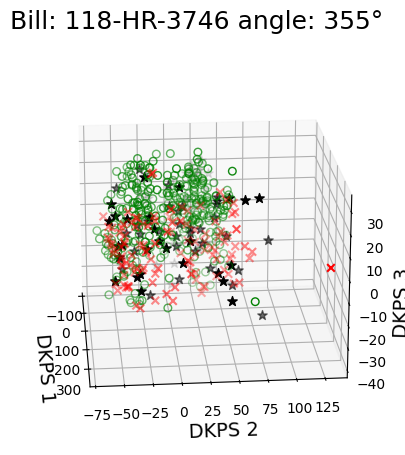

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Color dictionary for each vote type
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'tab:blue'}

bill=bi_cameral_bills[3]
    
    # Set up figure and 3D axes
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
    
    # Retrieve vote list and indices for house and senate voters
vote_list = vote_by_bill[bill]
voter_inds_house_no = np.array([i for i, v in enumerate(vote_list) if v == 'nay' and chamber_by_bill[bill][i] == 'house'])
voter_inds_house_yes = np.array([i for i, v in enumerate(vote_list) if v == 'yea' and chamber_by_bill[bill][i] == 'house'])
voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    
    # Retrieve 3D coordinates
cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))
    # Scatter plot for House "No" votes as red 'x'
ax.scatter(
        cmds_generated[voter_inds_house_no, 0], 
        cmds_generated[voter_inds_house_no, 1], 
        cmds_generated[voter_inds_house_no, 2], 
        color='red', 
        marker='x', 
        s=30, 
        label='House No'
    )
    
    # Scatter plot for House "Yes" votes as hollow green circles
ax.scatter(
        cmds_generated[voter_inds_house_yes, 0], 
        cmds_generated[voter_inds_house_yes, 1], 
        cmds_generated[voter_inds_house_yes, 2], 
        edgecolor='green', 
        facecolor='none', 
        marker='o', 
        s=30, 
        label='House Yes'
    )

    # Scatter plot for Senators with black stars and color density based on rescaled flip score
all_names = [senate_flip_score[bill]['name_list'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]]
flip_scores = np.array([senate_flip_score[bill]['flip_score_2'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1]])
    
    # Rescale flip scores to range 0 to 1
flip_score_min = flip_scores.min()
flip_score_max = flip_scores.max()
color_density = (flip_scores - flip_score_min) / (flip_score_max - flip_score_min)*0.9+0.1
    
for i, name in enumerate(all_names):
    ax.scatter(
            cmds_dict[bill]['generated'][name][0], 
            cmds_dict[bill]['generated'][name][1],
            cmds_dict[bill]['generated'][name][2],
            color='black', 
            marker='*', 
            s=50, 
            alpha=color_density[i]  # Set transparency based on normalized flip score
        )
    # Set axis labels and plot title
ax.set_xlabel('DKPS 1', fontsize=14)
ax.set_ylabel('DKPS 2', fontsize=14)
ax.set_zlabel('DKPS 3', fontsize=14)
#fig.suptitle(f'Bill: {bill} angle', fontsize=18)
    
    # Define the update function for rotation
def rotate(angle):
    ax.view_init(elev=20, azim=angle)
    fig.suptitle(f'Bill: {bill} angle: {angle}°', fontsize=18)

    # Create animation, rotating from 0 to 360 degrees
anim = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 5), interval=100)
    
    # Save animation (optional)
anim.save(f'rotation_bill_{bill}.gif', writer='imagemagick', fps=2)

    # Display plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Color dictionary for each vote type
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'tab:blue'}

# Select four bills to display in a 2x2 grid
selected_bills = bi_cameral_bills[:4]

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Loop over the selected bills and respective subplot locations
for idx, bill in enumerate(selected_bills):
    
    # Determine the position in the 2x2 grid
    row, col = divmod(idx, 2)
    ax = axs[row, col]
    
    # Retrieve vote list and indices for house and senate voters
    vote_list = vote_by_bill[bill]
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    # Retrieve 2D coordinates (first two dimensions)
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))
    
    # Scatter plot for house and senate voters
    ax.scatter(
        cmds_generated[voter_inds_house, 0], 
        cmds_generated[voter_inds_house, 1], 
        c=[vote_color_dict[p] for p in vote_list[voter_inds_house]], 
        s=5, 
        label='House'
    )
    ax.scatter(
        cmds_generated[voter_inds_senate, 0], 
        cmds_generated[voter_inds_senate, 1], 
        #c=[vote_color_dict[p] for p in vote_list[voter_inds_senate]], 
        c='tab:grey',
        marker='*', 
        s=50, 
        label='Senate'
    )

    # Highlight top 10 names with black 'x' markers, scaled by flip score
    top_10_names = [senate_flip_score[bill]['name_list'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1][:10]]
    flip_scores = np.array([senate_flip_score[bill]['flip_score_2'][i] for i in np.argsort(senate_flip_score[bill]['flip_score_2'])[::-1][:10]])
    # Normalize and scale flip scores for marker sizes (optional: adjust scaling factor as needed)
    min_size, max_size = 30, 100
    if flip_scores.max() == flip_scores.min():
        scaled_sizes = np.full_like(flip_scores, min_size)
    else:
        scaled_sizes = min_size + (flip_scores - flip_scores.min()) / (flip_scores.max() - flip_scores.min()) * (max_size - min_size)
    
    for name, size in zip(top_10_names, scaled_sizes):
        ax.scatter(
            cmds_dict[bill]['generated'][name][0], 
            cmds_dict[bill]['generated'][name][1], 
            color='black', 
            marker='x', 
            s=size
        )
    
    # Set axis labels and plot title for each subplot
    ax.set_xlabel('DKPS 1', fontsize=10)
    ax.set_ylabel('DKPS 2', fontsize=10)
    ax.set_title(f'Bill: {bill}', fontsize=12)
    ax.legend()

# Adjust layout for a cleaner appearance
plt.tight_layout()
plt.show()

In [200]:
cmds_dict['117-HR-1319']['generated'].keys()

dict_keys(['ken_buck', 'kat_cammack', 'dennis_ross', 'richard_hudson', 'chip_roy', 'jim_banks', 'kevin_hern', 'jim_bridenstine', 'michelle_grisham', 'jimmy_gomez', 'joe_neguse', 'maria_cantwell', 'tom_graves', 'mike_fitzpatrick', 'marcy_kaptur', 'anna_luna', 'karen_bass', 'orrin_hatch', 'lauren_underwood', 'darin_lahood', 'elizabeth_warren', 'michelle_steel', 'mike_doyle', 'joe_courtney', 'bradley_byrne', 'pete_stauber', 'lois_frankel', 'judy_chu', 'lucille_roybal-allard', 'morgan_griffith', 'matt_cartwright', 'dwight_evans', 'sylvia_garcia', 'pramila_jayapal', 'kim_schrier', 'david_mckinley', 'mitt_romney', 'david_trone', 'john_garamendi', 'matt_gaetz', 'rick_larsen', 'tim_ryan', 'jason_crow', 'kevin_brady', 'robert_casey', 'bill_hagerty', 'thomas_massie', 'william_keating', 'jim_mcgovern', 'barry_loudermilk', 'claudia_tenney', 'john_curtis', 'richard_shelby', 'lisa_rochester', 'mike_quigley', 'alma_adams', 'patrick_leahy', 'jon_tester', 'steve_womack', 'susan_collins', 'michael_benne

In [63]:
df_senate_check = pd.read_csv(f"/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{bill_meta[bi_cameral_bills[1]]['senate_vote_id']}.csv", header=0)
## cell for sanity check they all matched
kk=4
print(senate_flip_score[bi_cameral_bills[1]]['name_list'][kk], senate_flip_score[bi_cameral_bills[1]]['party'][kk], senate_flip_score[bi_cameral_bills[1]]['true_votes'][kk], senate_flip_score[bi_cameral_bills[1]]['cross_party_line'][kk])
key = next(key for key, value in name_to_standardized_name.items() if value == senate_flip_score[bi_cameral_bills[1]]['name_list'][kk])
df_senate_check = pd.read_csv(f"/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{bill_meta[bi_cameral_bills[1]]['senate_vote_id']}.csv", header=0)
matched_row = df_senate_check[df_senate_check['matched-name'] == key][[ 'matched-name' ,'party', 'vote']]
print(matched_row)

bill_hagerty r yea True
         matched-name       party vote
96  Bill Hagerty R-TN  Republican  Yea


In [42]:
## senate who votes in all four bills
import random

senate_intersection =  list(set(senate_flip_score[bi_cameral_bills[0]]['name_list']) & set(senate_flip_score[bi_cameral_bills[1]]['name_list']) & set(senate_flip_score[bi_cameral_bills[2]]['name_list']) & set(senate_flip_score[bi_cameral_bills[3]]['name_list']) )
random_senators = random.sample(senate_intersection, 10)
print(random_senators)
len(set(senate_flip_score[bi_cameral_bills[0]]['name_list']) & set(senate_flip_score[bi_cameral_bills[1]]['name_list']) & set(senate_flip_score[bi_cameral_bills[2]]['name_list']) & set(senate_flip_score[bi_cameral_bills[3]]['name_list']) )

['tim_scott', 'thomas_carper', 'john_thune', 'maggie_hassan', 'ben_cardin', 'jon_tester', 'mitt_romney', 'mike_crapo', 'james_lankford', 'thom_tillis']


78

['angus_king',
 'josh_hawley',
 'susan_collins',
 'thom_tillis',
 'ron_wyden',
 'shelley_capito',
 'sheldon_whitehouse',
 'bill_cassidy',
 'rand_paul',
 'roger_wicker']

In [48]:
df

,Bill,Flip Score,Name,Party,Vote
0,117-HR-1319,0.000000,maria_cantwell,d,yea
1,117-HR-1319,0.640000,elizabeth_warren,d,yea
2,117-HR-1319,0.000000,mitt_romney,r,nay
3,117-HR-1319,0.840000,robert_casey,d,yea
4,117-HR-1319,0.000000,bill_hagerty,r,nay
...,...,...,...,...,...
358,118-HR-3746,0.248889,john_fetterman,d,nay
359,118-HR-3746,0.248889,john_hickenlooper,d,yea
360,118-HR-3746,0.462222,mike_crapo,r,nay
361,118-HR-3746,0.000000,mark_warner,d,yea
